In [1]:
from nltk.corpus import stopwords
from nltk import sent_tokenize
from nltk import word_tokenize
from pymorphy2 import MorphAnalyzer

import re

import spacy
import spacy_spanish_lemmatizer

In [2]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def show_wordcloud_by_freq_dict(freq_dict):
    
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=freq_dict)
    
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


In [3]:
spanish_stopwords = stopwords.words('spanish')
russian_stopwords = stopwords.words('russian')

morph = MorphAnalyzer()

nlp = spacy.load("es_core_news_sm")
nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")

In [6]:
def clean_punctuation(sentence):
    return re.sub("([^\w\s])|([0-9]+)","", sentence)

def clean_stopwords(words, stopwords):
    result = []
    for word in words: 
        if word.lower() not in stopwords:
            result.append(word)
    return result
        
def tokenize_sentences(doc):
    return list(sent_tokenize(doc))

def tokenize_words(sentence):
    st = clean_punctuation(sentence)
    return word_tokenize(st.lower())

def lemmatize_rus(words):
    lemmatized_words = [morph.parse(word)[0].normal_form for word in words]
    return lemmatized_words

# def tokenize_lemmatize_esp(sentence):
#     lemmatized_words = []
#     for token in nlp(sentence):
#         lemmatized_words.append(token.lemma_)
#     return lemmatized_words

def lemmatize_esp(words):
    lemmatized_words = []
    for token in nlp(' '.join(words)):
        lemmatized_words.append(token.lemma_)
    return lemmatized_words

In [54]:
with open('C:/Users/rigel/Desktop/ВШЭ/Python/обезличенный_RUS.txt', 'r', encoding='utf-8') as file:
    doc_rus = file.read()

Создаем русский и испанский корпуса(список списков): нелемматизированный (с токенизацией на предложения и слова) и лемматизированный. 

In [55]:
corpus_rus = []
lemmatized_corpus_rus = []

sentences = tokenize_sentences(doc_rus)

for sentence in sentences:
    words = tokenize_words(sentence)
    words = clean_stopwords(words, russian_stopwords)
    corpus_rus.append(words)
    lemmatized_words = lemmatize_rus(words)
    lemmatized_corpus_rus.append(lemmatized_words)

# print(corpus_rus)
# print(lemmatized_corpus_rus)

In [31]:
with open('C:/Users/rigel/Desktop/ВШЭ/Python/обезличенный_ESP.txt', 'r', encoding='utf-8') as file:
    doc_esp = file.read()

In [10]:
corpus_esp = []
lemmatized_corpus_esp = []

sentences = tokenize_sentences(doc_esp)

for sentence in sentences:
    words = tokenize_words(sentence)
    words = clean_stopwords(words, spanish_stopwords)
    corpus_esp.append(words)
    lemmatized_words = lemmatize_esp(words)
    lemmatized_corpus_esp.append(lemmatized_words)

# print(corpus_esp)
# print(lemmatized_corpus_esp)

Объем русского корпуса 679 предложений, испанского 572 предложения.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict as dd # удобный словарик
from operator import itemgetter # способ доставать n-ый элемент из iterable

tf-idf анализ для лемматизированных корпусов.

In [56]:
def tf_idf(corpus):
    text = [' '.join(words) for words in corpus]

    tfidf_vectorizer = TfidfVectorizer()

    tfidf_vectorizer.fit_transform(text) 
    feature_names = tfidf_vectorizer.get_feature_names_out()

    X = tfidf_vectorizer.transform(text)
    col_nums = set(X.nonzero()[1])
    tfidf_scores = [(feature_names[col], X[0, col]) for col in col_nums]

    freq_list = [(word, freq) for word, freq in sorted(tfidf_scores, 
                                                       key=itemgetter(1), 
                                                       reverse=True)]
    return freq_list

документация	0.5661378295322549
пояснительный	0.28306891476612744
проектнотехнический	0.28306891476612744
тендер	0.28306891476612744
участие	0.28306891476612744
гидромеханический	0.26605167251682427
гидроэнергетический	0.2304908495034692
разработка	0.2304908495034692
технический	0.21994326249467425
приложение	0.2155213150012726


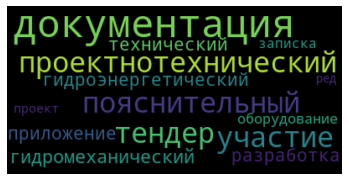

In [57]:
freq_list = tf_idf(lemmatized_corpus_rus)

for word, freq in freq_list[:10]:
    print('\t'.join((word, str(freq))))

show_wordcloud_by_freq_dict(dict(freq_list))

anexo	0.4072697497724083
hidromecánico	0.4072697497724083
licitación	0.3306352502448971
técnico	0.3306352502448971
hidroeléctrico	0.32246681638922337
documento	0.3152617471004983
memoria	0.30298624191450957
proyecto	0.23395533025601004
rev	0.20363487488620416
diseño	0.1933800405411658


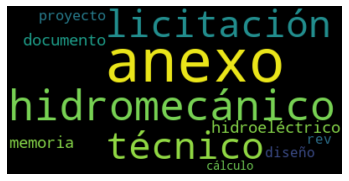

In [34]:
freq_list = tf_idf(lemmatized_corpus_esp)

for word, freq in freq_list[:10]:
    print('\t'.join((word, str(freq))))

show_wordcloud_by_freq_dict(dict(freq_list))

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

In [35]:
def text_from_corpus(corpus): # функция, "склеивающая" слова обратно в предложения и в текст, нужна для bigram vectorizer. 
    text = ''
    for words in corpus:
        text = text + ' '.join(words) + '. '
    return text

Извлечем и посчитаем все n-граммы из слов с помощью bigram_vectorizer для корпусов из библиотеки sklearn.

In [36]:
bigram_vectorizer_rus = CountVectorizer(ngram_range=(3,3),
                                    token_pattern=r'[а-яА-ЯёЁ]+', min_df=1) # используем импортированный модуль
# изменяемые параметры: 
# token_pattern=r'здесь регулярка', которая задает искомый паттерн
# ngram_range=(от,до) задает количество n-грамм (например, найти все от 2грамм до 4грамм)

analyze_rus = bigram_vectorizer_rus.build_analyzer() # применили функцию, сохранили в переменную

Проанализируем n-граммы сначала на токенизированном тексте без лемматизации, затем на лемматизированном. Получаем список n-грамм, а Counter покажет наиболее частотные n-граммы.

In [58]:
z = analyze_rus(doc_rus)

Counter(z).most_common()

[('со стороны щита', 74),
 ('модуль устойчивый к', 64),
 ('общий вес затвора', 61),
 ('спецификации по материалам', 60),
 ('м над уровнем', 60),
 ('над уровнем моря', 60),
 ('расчет толщины щита', 54),
 ('максимальный момент на', 53),
 ('высота применения силы', 48),
 ('применения силы лошадиных', 48),
 ('силы лошадиных сил', 48),
 ('распределенная нагрузка на', 46),
 ('ссылки и стандарты', 44),
 ('к растяжению со', 42),
 ('растяжению со стороны', 42),
 ('удельный вес стали', 42),
 ('вес закладных частей', 41),
 ('мм максимальный момент', 41),
 ('составляет кг вес', 41),
 ('составляет н мм', 37),
 ('толщины щита расчет', 36),
 ('сила сдвига в', 36),
 ('в нормальных условиях', 36),
 ('необходимый модуль сопротивления', 34),
 ('расчет центра тяжести', 32),
 ('устойчивый к растяжению', 32),
 ('устойчивый к сжатию', 32),
 ('выбранная толщина листа', 32),
 ('с помощью следующего', 32),
 ('помощью следующего уравнения', 32),
 ('мм модуль устойчивый', 32),
 ('вес горизонтальных балок', 30),
 

In [59]:
text_rus = text_from_corpus(lemmatized_corpus_rus)

z = analyze_rus(text_rus)

Counter(z).most_common()

[('растяжение сторона щит', 68),
 ('общий вес затвор', 63),
 ('необходимый модуль сопротивление', 60),
 ('м уровень море', 60),
 ('расчёт толщина щит', 54),
 ('модуль устойчивый растяжение', 48),
 ('высота применение сила', 48),
 ('применение сила лошадиный', 48),
 ('вес горизонтальный балка', 46),
 ('модуль устойчивый сжатие', 46),
 ('устойчивый растяжение сторона', 42),
 ('вес закладная часть', 41),
 ('уравнение такой образ', 41),
 ('составлять кг вес', 41),
 ('следующий уравнение такой', 37),
 ('толщина щит расчёт', 36),
 ('сила трение уплотнитель', 36),
 ('наиболее критический модуль', 36),
 ('сила лошадиный сила', 36),
 ('расчёт центр тяжесть', 32),
 ('максимальный момент балка', 32),
 ('выбрать толщина лист', 32),
 ('помощь следующий уравнение', 32),
 ('мм модуль устойчивый', 32),
 ('распределённый нагрузка вторичный', 30),
 ('нагрузка вторичный арматура', 30),
 ('значение модуль устойчивый', 30),
 ('нормальный условие мпа', 30),
 ('такой образ мм', 29),
 ('прогиб отношение проги

In [47]:
bigram_vectorizer_esp = CountVectorizer(ngram_range=(3, 4),
                                    token_pattern=r'[a-zA-ZáéíñóúüÁÉÍÑÓÚÜ]+', min_df=1) # используем импортированный модуль
# изменяемые параметры: 
# token_pattern=r'здесь регулярка', которая задает искомый паттерн
# ngram_range=(от,до) задает количество n-грамм (например, найти все от 2грамм до 4грамм)

analyze_esp = bigram_vectorizer_esp.build_analyzer() # применили функцию, сохранили в переменную

In [50]:
z = analyze_esp(doc_esp)

Counter(z).most_common()

[('módulo resistente a la', 80),
 ('peso de los refuerzos', 70),
 ('de las vigas horizontales', 66),
 ('la sección x x', 62),
 ('especificaciones de los materiales', 61),
 ('peso total de la', 61),
 ('de aplicación de la', 57),
 ('esfuerzo a la tracción', 56),
 ('total de la compuerta', 55),
 ('aplicación de la fuerza', 55),
 ('del espesor del escudo', 54),
 ('el peso de los', 53),
 ('de los refuerzos verticales', 52),
 ('momento máximo en la', 50),
 ('del centro de gravedad', 48),
 ('inercia de la viga', 48),
 ('resistente a la tracción', 48),
 ('resistente a la compresión', 48),
 ('altura de aplicación de', 48),
 ('en la sección x', 46),
 ('el valor de la', 45),
 ('sección de la viga', 44),
 ('cálculo del espesor del', 42),
 ('en el lado del', 40),
 ('el lado del escudo', 40),
 ('esfuerzo a la compresión', 40),
 ('peso especifico del acero', 37),
 ('peso de las vigas', 34),
 ('distribución de la estructura', 34),
 ('a la tracción en', 34),
 ('la tracción en el', 34),
 ('tracción en e

In [51]:
text_esp = text_from_corpus(lemmatized_corpus_esp)

z = analyze_esp(text_esp)

Counter(z).most_common()

[('resistente tracción lado escudo', 42),
 ('altura aplicación fuerza hrs', 34),
 ('módulo resistente tracción lado', 28),
 ('s y mpa esfuerzo', 26),
 ('especificación materiales esfuerzo admisible', 25),
 ('peso total tablero wt', 25),
 ('tracción lado escudo wt', 25),
 ('formulas for stress and', 25),
 ('for stress and strain', 25),
 ('stress and strain ed', 25),
 ('esfuerzo admisible coeficiente rozamiento', 24),
 ('cálculo presión media panel', 24),
 ('módulo resistente compresión wc', 24),
 ('carga distribuido refuerzo secundario', 24),
 ('peso viga horizontal wvigas', 24),
 ('viga horizontal wvigas h', 24),
 ('peso refuerzos intermedios wri', 24),
 ('refuerzos inferior superior wris', 24),
 ('peso estimado embebido wembebidos', 24),
 ('peso total compuerta wtotal', 24),
 ('roarks formulas for stress', 23),
 ('coeficiente rozamiento procedimiento cálculo', 22),
 ('esfuerzo cortante esfuerzo cortante', 22),
 ('ancho placa refuerzo inferior', 22),
 ('calcular mediante siguiente ecua

In [25]:
from nltk.util import ngrams
# ngrams - это встроенная функция в модуле nltk

Далее второй способ получения ngrams из библиотеки NLTK.

In [41]:
def ngrams_by_nltk(corpus, num):
    ngramvalues = []

    for words in corpus:
        ng = list(ngrams(words, num))
        ngramvalues.extend(ng)

    return ngramvalues

In [60]:
ngramvalues = ngrams_by_nltk(lemmatized_corpus_rus, 3)

Counter(ngramvalues).most_common()

[(('растяжение', 'сторона', 'щит'), 68),
 (('общий', 'вес', 'затвор'), 63),
 (('необходимый', 'модуль', 'сопротивление'), 60),
 (('м', 'уровень', 'море'), 58),
 (('расчёт', 'толщина', 'щит'), 54),
 (('модуль', 'устойчивый', 'растяжение'), 48),
 (('высота', 'применение', 'сила'), 48),
 (('применение', 'сила', 'лошадиный'), 48),
 (('вес', 'горизонтальный', 'балка'), 46),
 (('модуль', 'устойчивый', 'сжатие'), 46),
 (('устойчивый', 'растяжение', 'сторона'), 42),
 (('вес', 'закладная', 'часть'), 41),
 (('толщина', 'щит', 'расчёт'), 36),
 (('сила', 'трение', 'уплотнитель'), 36),
 (('наиболее', 'критический', 'модуль'), 36),
 (('сила', 'лошадиный', 'сила'), 36),
 (('расчёт', 'центр', 'тяжесть'), 32),
 (('инерция', 'балка', 'i'), 32),
 (('максимальный', 'момент', 'балка'), 32),
 (('момент', 'сечение', 'xx'), 32),
 (('выбрать', 'толщина', 'лист'), 32),
 (('помощь', 'следующий', 'уравнение'), 32),
 (('распределённый', 'нагрузка', 'вторичный'), 30),
 (('нагрузка', 'вторичный', 'арматура'), 30),
 

In [61]:
ngramvalues = ngrams_by_nltk(lemmatized_corpus_esp, 3)

Counter(ngramvalues).most_common()

[(('tracción', 'lado', 'escudo'), 62),
 (('peso', 'total', 'compuerta'), 57),
 (('modulo', 'resistente', 'requerido'), 52),
 (('altura', 'aplicación', 'fuerza'), 48),
 (('peso', 'viga', 'horizontal'), 47),
 (('módulo', 'resistente', 'compresión'), 46),
 (('inercia', 'viga', 'i'), 45),
 (('sy', 'mpa', 'esfuerzo'), 43),
 (('cálculo', 'espesor', 'escudo'), 42),
 (('resistente', 'tracción', 'lado'), 42),
 (('módulo', 'resistente', 'tracción'), 34),
 (('aplicación', 'fuerza', 'hrs'), 34),
 (('momento', 'grande', 'viga'), 32),
 (('esfuerzo', 'compresión', 'σc'), 32),
 (('carga', 'distribuido', 'refuerzo'), 32),
 (('distribuido', 'refuerzo', 'secundario'), 30),
 (('grande', 'sección', 'xx'), 30),
 (('acero', 'acero', 'lubricado'), 28),
 (('mediante', 'siguiente', 'ecuación'), 28),
 (('centro', 'gravedad', 'cg'), 27),
 (('fuerza', 'cortante', 'grande'), 27),
 (('stress', 'and', 'strain'), 27),
 (('kg', 'peso', 'total'), 27),
 (('peso', 'total', 'tablero'), 26),
 (('peso', 'escudo', 'wescudo'),

tf-idf для коллокаций, Tfidf-Vectorizer Sklearn

In [52]:
def corpus_to_sentences(corpus):
    sentences = []
    for words in corpus:
        sentences.append(' '.join(words))
    return sentences

In [62]:
tfidf_rus = TfidfVectorizer(min_df=2, max_df=0.7,
                            max_features=100,
                            ngram_range=(2,3))

tokenized_lemmatized_text = corpus_to_sentences(lemmatized_corpus_rus)

tfidf_rus.fit(tokenized_lemmatized_text)

tfidf_rus.vocabulary_

{'сегментный затвор': 72,
 'спецификация материал': 80,
 'допустимый напряжение': 21,
 'коэффициент трение': 27,
 'расчёт толщина': 65,
 'толщина щит': 85,
 'щит расчёт': 99,
 'вертикальный балка': 5,
 'сила сдвиг': 76,
 'расчёт толщина щит': 66,
 'толщина щит расчёт': 86,
 'горизонтальный балка': 20,
 'сила трение': 77,
 'трение уплотнитель': 87,
 'вес затвор': 11,
 'вес щит': 13,
 'вторичный арматура': 14,
 'вес горизонтальный': 7,
 'общий вес': 51,
 'вес закладная': 9,
 'закладная часть': 22,
 'максимальный сила': 33,
 'сила трение уплотнитель': 78,
 'вес горизонтальный балка': 8,
 'общий вес затвор': 52,
 'вес закладная часть': 10,
 'плоский затвор': 55,
 'гидродинамический сила': 19,
 'верхний нижний': 6,
 'щит wt': 97,
 'ссылка стандарт': 81,
 'методика расчёт': 34,
 'наиболее критический': 45,
 'критический модуль': 28,
 'напряжение растяжение': 47,
 'расчёт центр': 67,
 'центр тяжесть': 96,
 'инерция балка': 24,
 'модуль устойчивый': 39,
 'устойчивый растяжение': 93,
 'растяжен

In [63]:
word2idf = []

for word, i in tfidf_rus.vocabulary_.items():
    word2idf.append((tfidf_rus.idf_[i], word))

sorted(word2idf, reverse=True)

[(5.135166556742356, 'кг вес'),
 (4.872802292274865, 'момент сечение xx'),
 (4.872802292274865, 'момент сечение'),
 (4.872802292274865, 'выбрать толщина лист'),
 (4.872802292274865, 'выбрать толщина'),
 (4.798694320121143, 'толщина лист'),
 (4.798694320121143, 'сила лошадиный сила'),
 (4.798694320121143, 'сила лошадиный'),
 (4.798694320121143, 'применение сила лошадиный'),
 (4.798694320121143, 'применение сила'),
 (4.798694320121143, 'определённый вес'),
 (4.798694320121143, 'момент балка'),
 (4.798694320121143, 'максимальный момент балка'),
 (4.798694320121143, 'лошадиный сила'),
 (4.798694320121143, 'высота применение сила'),
 (4.798694320121143, 'высота применение'),
 (4.7297014486341915, 'прогиб составлять'),
 (4.66516292749662, 'уровень море'),
 (4.66516292749662, 'ребро жёсткость'),
 (4.66516292749662, 'нормальный условие'),
 (4.66516292749662, 'наиболее критический модуль'),
 (4.66516292749662, 'критический модуль'),
 (4.66516292749662, 'sy мпа'),
 (4.547379891840237, 'вертикаль

In [64]:
tfidf_esp = TfidfVectorizer(min_df=2, max_df=0.7,
                            max_features=100,
                            ngram_range=(2,3))

tokenized_lemmatized_text = corpus_to_sentences(lemmatized_corpus_esp)

tfidf_esp.fit(tokenized_lemmatized_text)

tfidf_esp.vocabulary_

{'especificación materiales': 31,
 'esfuerzo admisible': 26,
 'coeficiente rozamiento': 10,
 'compuerta radial': 14,
 'espesor escudo': 33,
 'calculo fuerza': 5,
 'viga vertical': 98,
 'fuerza cortante': 37,
 'sección viga': 84,
 'viga horizontal': 96,
 'fuerza rozamiento': 40,
 'compuerta peso': 12,
 'peso escudo': 67,
 'peso total': 71,
 'total compuerta': 91,
 'peso total compuerta': 72,
 'peso viga': 73,
 'superior inferior': 88,
 'peso refuerzos': 70,
 'total tablero': 92,
 'peso estimado': 69,
 'peso viga horizontal': 74,
 'stop log': 87,
 'referencia normas': 76,
 'procedimiento cálculo': 75,
 'distribución estructura': 20,
 'fuerza total': 41,
 'panel cálculo': 66,
 'cálculo espesor': 17,
 'escudo cálculo': 24,
 'viga principal': 97,
 'esfuerzo compresión': 27,
 'centro gravedad': 9,
 'inercia viga': 46,
 'módulo resistente': 62,
 'resistente tracción': 81,
 'tracción lado': 93,
 'lado escudo': 48,
 'resistente compresión': 79,
 'carga distribuido': 6,
 'momento grande': 59,
 '

In [65]:
word2idf = []

for word, i in tfidf_esp.vocabulary_.items():
    word2idf.append((tfidf_esp.idf_[i], word))

sorted(word2idf, reverse=True)

[(5.15366113937852, 'sy mpa esfuerzo'),
 (5.15366113937852, 'sy mpa'),
 (5.048300623720694, 'kg peso'),
 (4.865979066926739, 'grande sección xx'),
 (4.865979066926739, 'grande sección'),
 (4.865979066926739, 'cortante grande'),
 (4.785936359253203, 'espesor seleccionado'),
 (4.785936359253203, 'caso normal'),
 (4.642835515612529, 'modulo crítico'),
 (4.642835515612529, 'escudo compuerta'),
 (4.517672372658524, 'panel cálculo'),
 (4.517672372658524, 'momento grande viga'),
 (4.517672372658524, 'lámina trs'),
 (4.517672372658524, 'fuerza hrs'),
 (4.517672372658524, 'carga distribuido refuerzo'),
 (4.517672372658524, 'aplicación fuerza hrs'),
 (4.517672372658524, 'altura aplicación fuerza'),
 (4.517672372658524, 'altura aplicación'),
 (4.460513958818575, 'wtotal compuerta'),
 (4.460513958818575, 'valor esfuerzo'),
 (4.460513958818575, 'sección xx'),
 (4.460513958818575, 'grande viga'),
 (4.406446737548299, 'peso estimado'),
 (4.406446737548299, 'mediante siguiente ecuación'),
 (4.40644673

Подсчет биграмм и триграмм для коллокаций NLTK. Также посмотрим сначала на токенизированном корпусе без лемматизации и с лемматизацией.

In [66]:
import nltk
from nltk.collocations import *

In [67]:
bigram_measures = nltk.collocations.BigramAssocMeasures() 
trigram_measures = nltk.collocations.TrigramAssocMeasures()

In [68]:
finder2 = BigramCollocationFinder.from_documents(corpus_rus)
finder2.nbest(bigram_measures.likelihood_ratio, 20)

[('таким', 'образом'),
 ('распределенная', 'нагрузка'),
 ('максимальный', 'момент'),
 ('горизонтальных', 'балок'),
 ('уровнем', 'моря'),
 ('спецификации', 'материалам'),
 ('модуль', 'сопротивления'),
 ('закладных', 'частей'),
 ('общий', 'вес'),
 ('стороны', 'щита'),
 ('центра', 'тяжести'),
 ('модуль', 'устойчивый'),
 ('вторичной', 'арматуры'),
 ('коэффициенты', 'трения'),
 ('допустимые', 'напряжения'),
 ('м', 'уровнем'),
 ('сечении', 'xx'),
 ('ребра', 'жесткости'),
 ('отношение', 'прогиба'),
 ('ссылки', 'стандарты')]

In [69]:
finder2_lemmatized = BigramCollocationFinder.from_documents(lemmatized_corpus_rus)
finder2_lemmatized.nbest(bigram_measures.likelihood_ratio, 20)

[('такой', 'образ'),
 ('горизонтальный', 'балка'),
 ('распределённый', 'нагрузка'),
 ('вторичный', 'арматура'),
 ('модуль', 'устойчивый'),
 ('модуль', 'сопротивление'),
 ('максимальный', 'момент'),
 ('центр', 'тяжесть'),
 ('закладная', 'часть'),
 ('растяжение', 'сторона'),
 ('спецификация', 'материал'),
 ('уровень', 'море'),
 ('сторона', 'щит'),
 ('сечение', 'xx'),
 ('ребро', 'жёсткость'),
 ('сила', 'сдвиг'),
 ('допустимый', 'напряжение'),
 ('следующий', 'уравнение'),
 ('сила', 'трение'),
 ('общий', 'вес')]

In [70]:
finder3 = TrigramCollocationFinder.from_documents(corpus_rus)
finder3.nbest(trigram_measures.likelihood_ratio, 20)

[('mwl', 'таким', 'образом'),
 ('pflh', 'таким', 'образом'),
 ('wle', 'таким', 'образом'),
 ('таким', 'образом', 'f'),
 ('таким', 'образом', 'p'),
 ('таким', 'образом', 'fe'),
 ('таким', 'образом', 'm'),
 ('таким', 'образом', 't'),
 ('таким', 'образом', 'frca'),
 ('flhhih', 'таким', 'образом'),
 ('таким', 'образом', 'ft'),
 ('таким', 'образом', 'fre'),
 ('таким', 'образом', 'g'),
 ('tbpad', 'таким', 'образом'),
 ('tmwt', 'таким', 'образом'),
 ('wtotallhh', 'таким', 'образом'),
 ('таким', 'образом', 'ac'),
 ('таким', 'образом', 'названы'),
 ('cmwc', 'таким', 'образом'),
 ('lhhм', 'таким', 'образом')]

In [71]:
finder3_lemmatized = TrigramCollocationFinder.from_documents(lemmatized_corpus_rus)
finder3_lemmatized.nbest(trigram_measures.likelihood_ratio, 20)

[('mwl', 'такой', 'образ'),
 ('pflh', 'такой', 'образ'),
 ('wle', 'такой', 'образ'),
 ('такой', 'образ', 'f'),
 ('такой', 'образ', 'p'),
 ('такой', 'образ', 'fe'),
 ('такой', 'образ', 'm'),
 ('такой', 'образ', 't'),
 ('такой', 'образ', 'frca'),
 ('flhhih', 'такой', 'образ'),
 ('такой', 'образ', 'ft'),
 ('такой', 'образ', 'fre'),
 ('такой', 'образ', 'g'),
 ('tbpad', 'такой', 'образ'),
 ('tmwt', 'такой', 'образ'),
 ('wtotallhh', 'такой', 'образ'),
 ('такой', 'образ', 'ac'),
 ('такой', 'образ', 'назвать'),
 ('cmwc', 'такой', 'образ'),
 ('lhhм', 'такой', 'образ')]

То же самое для испанского для нелемматизированного и для лемматизированного текста

In [72]:
finder2 = BigramCollocationFinder.from_documents(corpus_esp)
finder2.nbest(bigram_measures.likelihood_ratio, 20)

[('carga', 'distribuida'),
 ('momento', 'máximo'),
 ('refuerzo', 'secundario'),
 ('vigas', 'horizontales'),
 ('módulo', 'resistente'),
 ('modulo', 'resistente'),
 ('esfuerzos', 'admisibles'),
 ('centro', 'gravedad'),
 ('especificaciones', 'materiales'),
 ('stop', 'log'),
 ('lado', 'escudo'),
 ('coeficientes', 'rozamiento'),
 ('tracción', 'lado'),
 ('peso', 'total'),
 ('resistente', 'requerido'),
 ('siguiente', 'ecuación'),
 ('sección', 'xx'),
 ('kg', 'peso'),
 ('distribución', 'estructura'),
 ('referencias', 'normas')]

In [73]:
finder2_lemmatized = BigramCollocationFinder.from_documents(lemmatized_corpus_esp)
finder2_lemmatized.nbest(bigram_measures.likelihood_ratio, 20)

[('carga', 'distribuido'),
 ('viga', 'horizontal'),
 ('módulo', 'resistente'),
 ('modulo', 'resistente'),
 ('momento', 'grande'),
 ('refuerzo', 'secundario'),
 ('centro', 'gravedad'),
 ('stop', 'log'),
 ('esfuerzo', 'admisible'),
 ('lado', 'escudo'),
 ('coeficiente', 'rozamiento'),
 ('tracción', 'lado'),
 ('peso', 'total'),
 ('siguiente', 'ecuación'),
 ('especificación', 'materiales'),
 ('mpa', 'esfuerzo'),
 ('fuerza', 'rozamiento'),
 ('kg', 'peso'),
 ('esfuerzo', 'cortante'),
 ('sección', 'xx')]

In [74]:
finder3 = TrigramCollocationFinder.from_documents(corpus_esp)
finder3.nbest(trigram_measures.likelihood_ratio, 20)

[('módulo', 'resistente', 'requerido'),
 ('carga', 'distribuida', 'uniforme'),
 ('modulo', 'resistente', 'requerido'),
 ('carga', 'distribuida', 'wi'),
 ('carga', 'distribuida', 'refuerzo'),
 ('verticales', 'carga', 'distribuida'),
 ('tracción', 'lado', 'escudo'),
 ('carga', 'distribuida', 'w'),
 ('carga', 'distribuida', 'wipihrss'),
 ('carga', 'distribuida', 'wrv'),
 ('pi', 'carga', 'distribuida'),
 ('wc', 'carga', 'distribuida'),
 ('hrs', 'carga', 'distribuida'),
 ('emm', 'carga', 'distribuida'),
 ('wrs', 'carga', 'distribuida'),
 ('w', 'carga', 'distribuida'),
 ('proporcional', 'carga', 'distribuida'),
 ('wi', 'carga', 'distribuida'),
 ('apoyada', 'carga', 'distribuida'),
 ('carga', 'distribuida', 'refuerzos')]

In [75]:
finder3_lemmatized = TrigramCollocationFinder.from_documents(lemmatized_corpus_esp)
finder3_lemmatized.nbest(trigram_measures.likelihood_ratio, 20)

[('carga', 'distribuido', 'refuerzo'),
 ('carga', 'distribuido', 'uniforme'),
 ('carga', 'distribuido', 'wi'),
 ('módulo', 'resistente', 'requerido'),
 ('modulo', 'resistente', 'requerido'),
 ('tracción', 'lado', 'escudo'),
 ('carga', 'distribuido', 'w'),
 ('vertical', 'carga', 'distribuido'),
 ('carga', 'distribuido', 'wipihrss'),
 ('carga', 'distribuido', 'wrv'),
 ('pi', 'carga', 'distribuido'),
 ('wc', 'carga', 'distribuido'),
 ('hrs', 'carga', 'distribuido'),
 ('emm', 'carga', 'distribuido'),
 ('wrs', 'carga', 'distribuido'),
 ('w', 'carga', 'distribuido'),
 ('proporcional', 'carga', 'distribuido'),
 ('wi', 'carga', 'distribuido'),
 ('carga', 'distribuido', 'tomado'),
 ('mpa', 'carga', 'distribuido')]

Метод Rake - извлечение ключевых фраз.

In [76]:
import pandas as pd
from rake_nltk import Rake 

In [80]:
def get_phrases(doc, minimal : int, maximal : int):
    rake = Rake()
    rake.extract_keywords_from_text(doc)
    phrases = rake.get_ranked_phrases()
    result = []
    for phrase in phrases:
        words = phrase.lower().split()
        if minimal <= len(words) <= maximal:
            result.append(phrase)
    
    return result  

In [83]:
text_rus = text_from_corpus(lemmatized_corpus_rus)
set(get_phrases(text_rus, 4, 5))

{'hydraulic gates paulo cf',
 'hydraulic gates пауло цф',
 'materials asme american society',
 'p minpmax hihhi pminpmax',
 'pot кгмс pot лс',
 's_y мпа разрушать напряжение astm',
 'steel institute aisc american institute',
 'sy мпа разрушать напряжение astm',
 'σac допустимый усилие колонна стать',
 'анализироваться кронштейн больший нагрузка нижний',
 'допустимый усилие колонна стать',
 'значение высота подъём затвор основание',
 'значение инерция балка составлять',
 'значение инерция сечение равно',
 'значение координата x мм',
 'инерция профиль составлять trsars',
 'коэффициент проверить стандарт din',
 'коэффициент трение материал таблица',
 'м рисунок габарит уплотнитель',
 'мм длина круглый сегмент затвор',
 'мм расчёт координата x',
 'площадь поперечный сечение затвор равный',
 'принимать дать опубликовать roaks formulas',
 'равно мм b равно мм',
 'равный мм давать отношение',
 'расчёт сила действовать затвор',
 'рисунок длина круглый сегмент затвор',
 'толщина брус пластина р

In [84]:
text_esp = text_from_corpus(lemmatized_corpus_esp)
set(get_phrases(text_esp, 4, 6))

{'ab β ecuación utilizado cálculo tbpar',
 'agua abajo pie presa',
 'analizado solamente brazo cargado decir inferior',
 'asumir valor publicado roaks formulas',
 'calculo fuerza actuante compuertas',
 'calculo momento fuerza cortante viga vertical',
 'caso carga función tipo esfuerzo tabla',
 'caso carga función tipo esfuerzos tabla',
 'caso seleccionado malla grueso separación mm',
 'coeficiente posición brazo tabla',
 'coeficiente rozamiento diferentes material tabla',
 'coeficiente rozamiento materiales tabla',
 'contratista debe justificar diseño procedimiento adoptado',
 'cs factor presión sedimentos variar',
 'diagrama momento viga horizontal siguiente forma',
 'dimensión cotas nivel agua referencia altolargo',
 'din part hydraulic steel structures criteria',
 'dos procedimiento bastante explicativo ref',
 'esfuerzo tracción compresión perfil determinar σmci',
 'espesor escudo sido calcular previamente',
 'final proceso iterativo llega solución definitivo',
 'hydraulic gates pau

In [276]:
import pandas as pd

In [277]:
print(len(corpus_rus))
print(len(corpus_esp))

679
572


In [225]:
# sentences_rus = list(sent_tokenize(doc_rus))
# sentences_esp = list(sent_tokenize(doc_esp))
# d = []

# for i in range(0, len(sentences_esp)):
#     d.append([sentences_esp[i], sentences_rus[i]])

In [85]:
# data = {}

# for idx, value in enumerate(d):
#     data.update({idx:value})
    
# my_dataframe = pd.DataFrame.from_dict(data, columns=["испанский","русский"], orient = 'index')

# print(my_dataframe)

Найдем некоторые примеры полученных словосочетаний (tf-idf для коллокаций, Tfidf-Vectorizer Sklearn) в основном корпусе НКРЯ.
'сегментный затвор':  
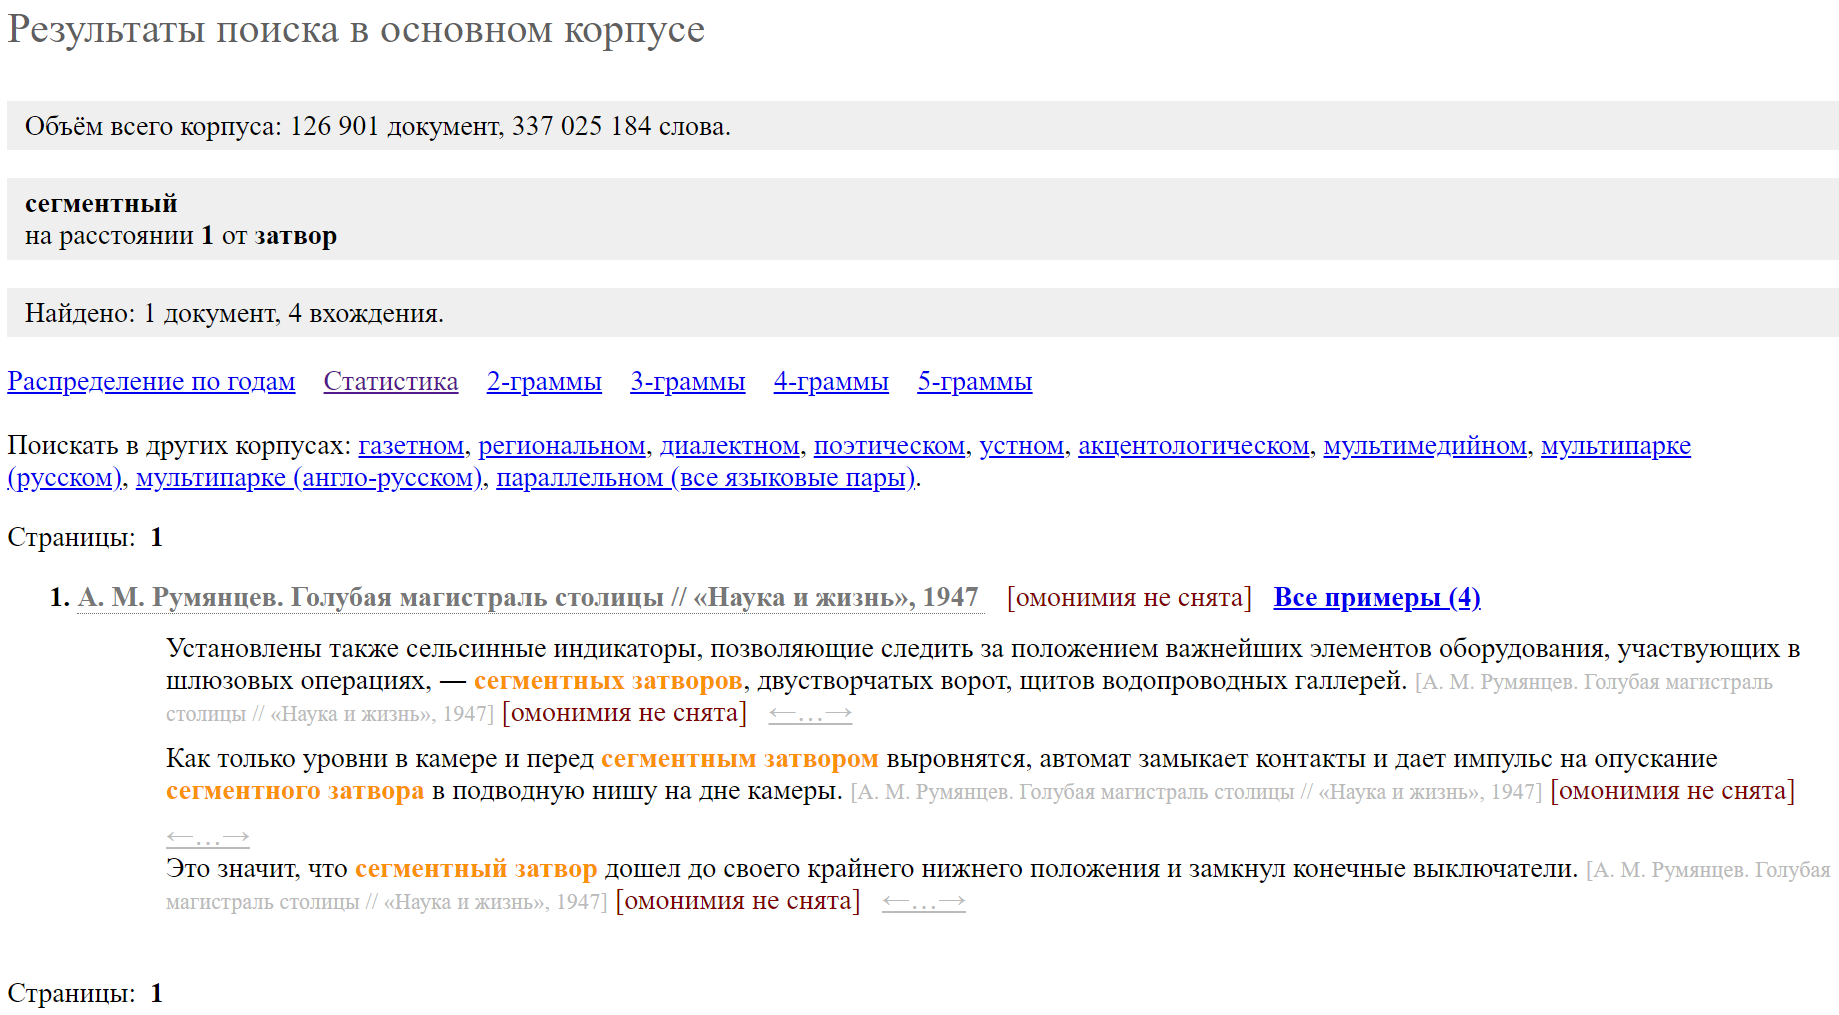 https://processing.ruscorpora.ru/search.xml?env=alpha&api=1.0&mycorp=&mysent=&mysize=&mysentsize=&dpp=10&spp=50&spd=10&mydocsize=&mode=main&lang=ru&sort=i_grtagging&nodia=1&text=lexgramm&parent1=0&level1=0&lex1=%D1%81%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B9&gramm1=&sem1=&flags1=&sem-mod1=sem&sem-mod1=semx&morph1=&parent2=0&level2=0&min2=1&max2=1&lex2=%D0%B7%D0%B0%D1%82%D0%B2%D0%BE%D1%80&gramm2=&sem2=&flags2=&sem-mod2=sem&sem-mod2=semx&morph2=

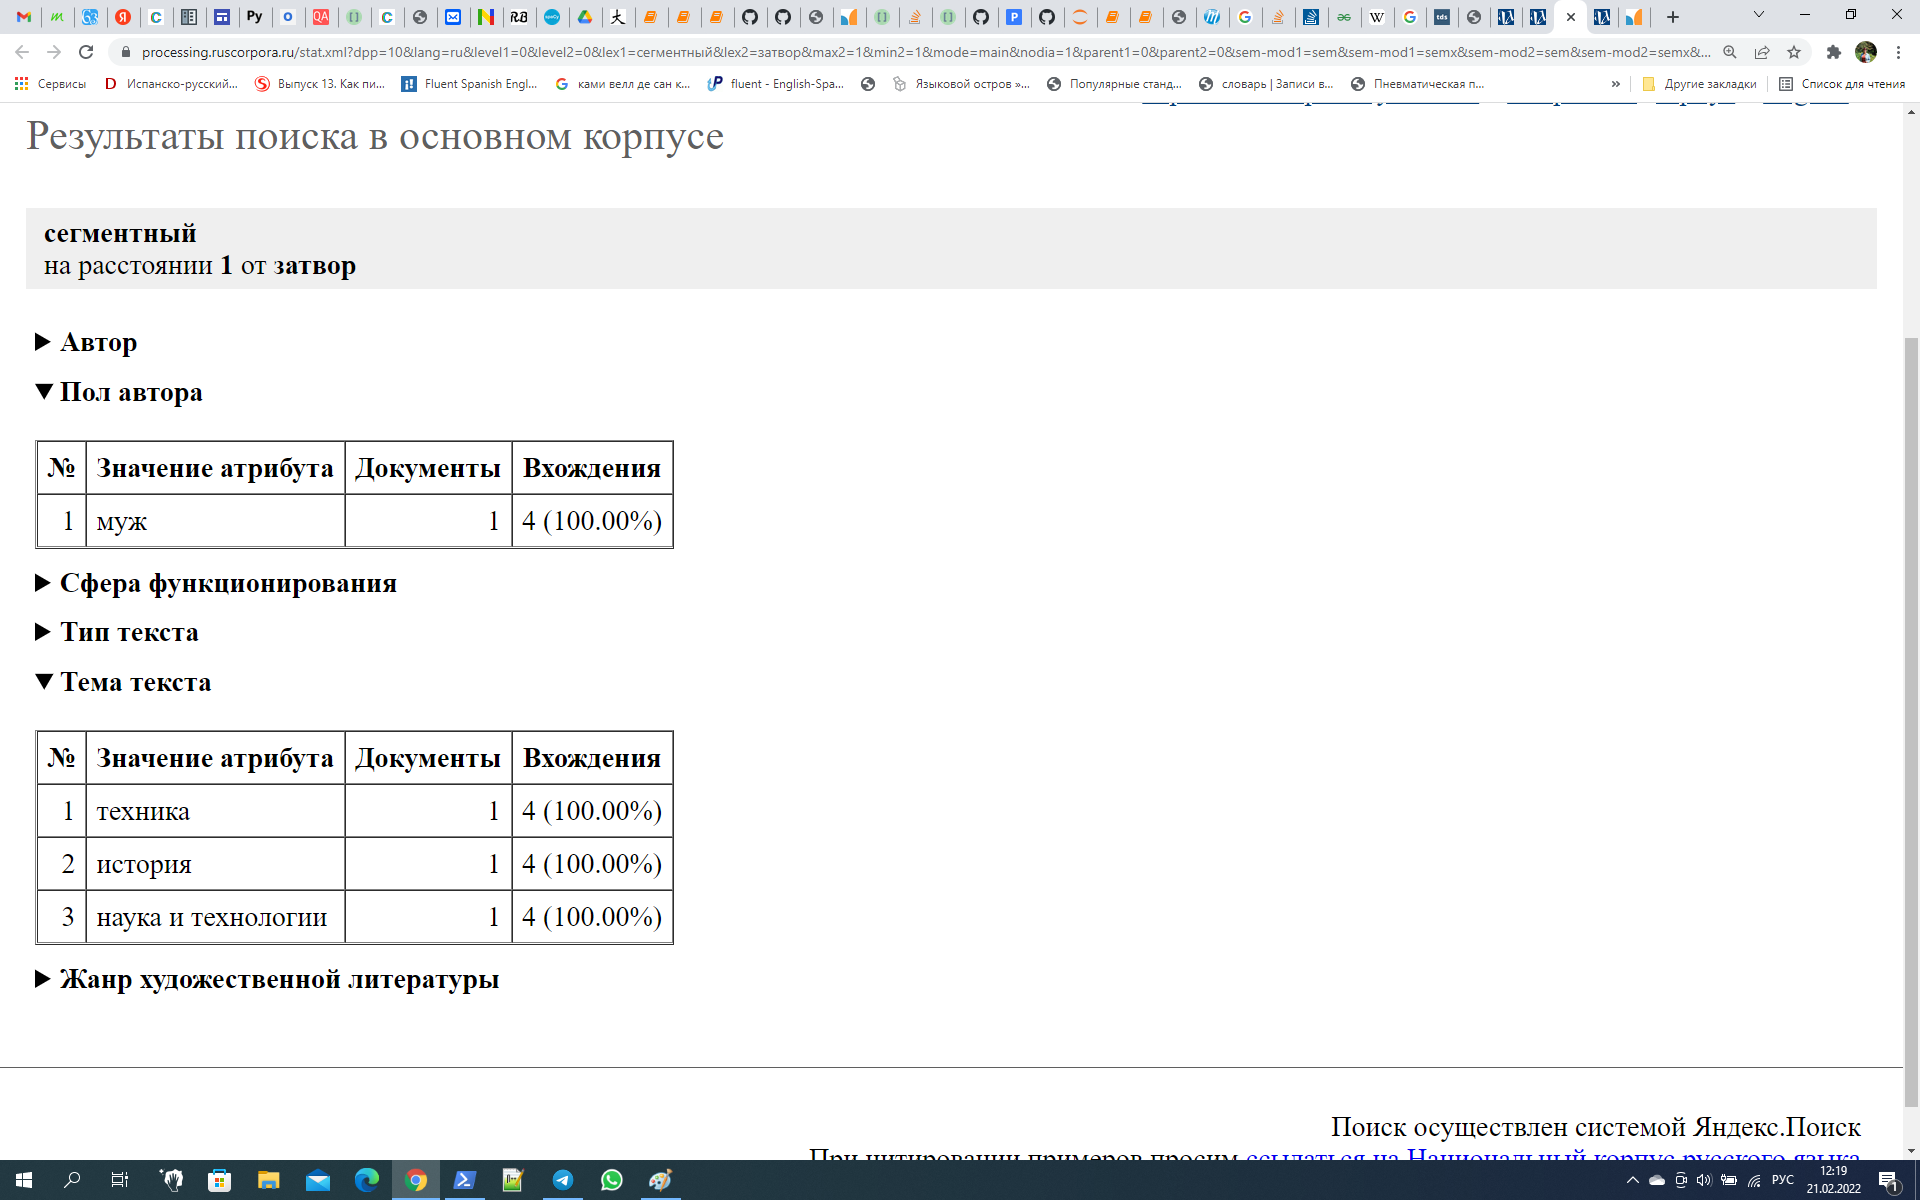 https://processing.ruscorpora.ru/stat.xml?dpp=10&lang=ru&level1=0&level2=0&lex1=%D1%81%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B9&lex2=%D0%B7%D0%B0%D1%82%D0%B2%D0%BE%D1%80&max2=1&min2=1&mode=main&nodia=1&parent1=0&parent2=0&sem-mod1=sem&sem-mod1=semx&sem-mod2=sem&sem-mod2=semx&sort=i_grtagging&spd=10&spp=50&text=lexgramm

'горизонтальный балка': 
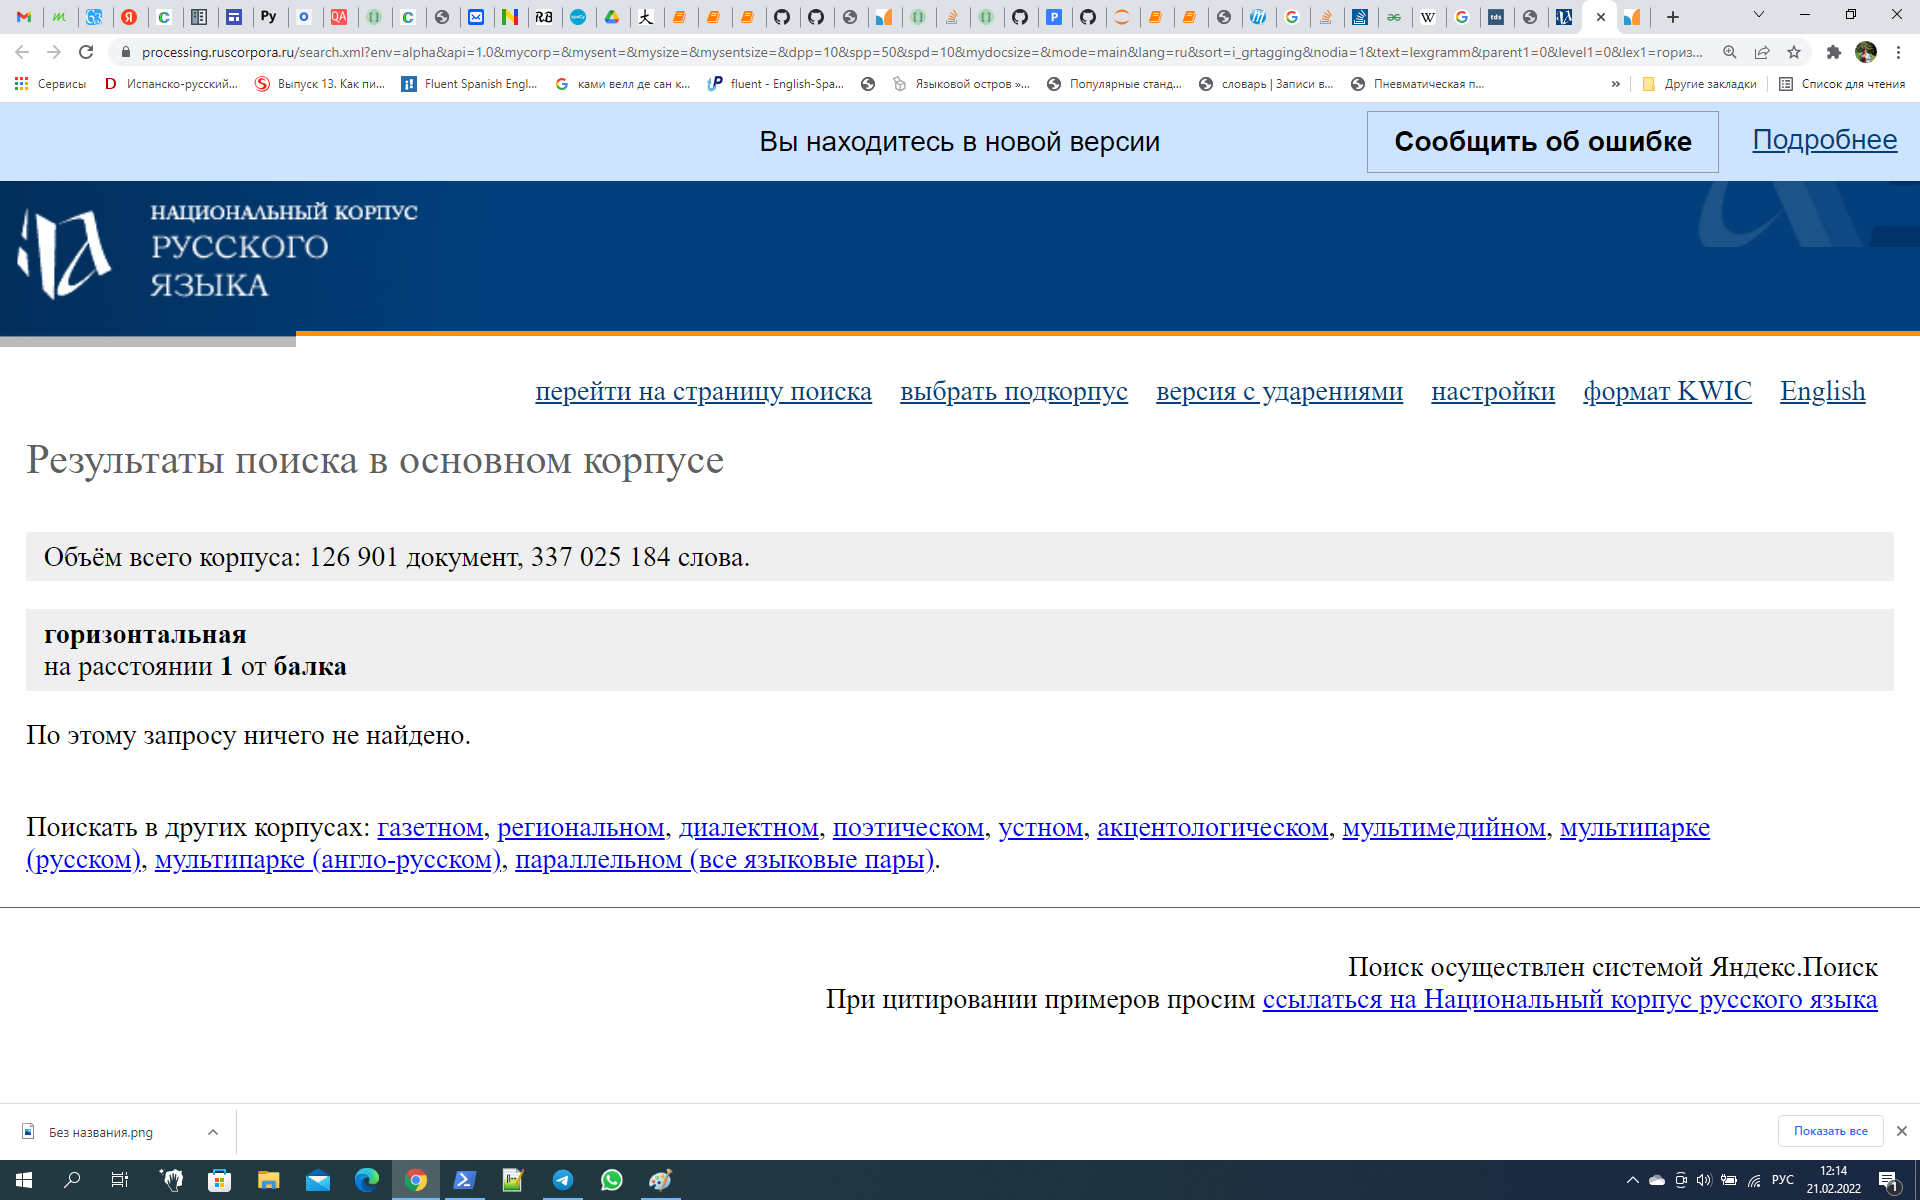 https://processing.ruscorpora.ru/search.xml?env=alpha&api=1.0&mycorp=&mysent=&mysize=&mysentsize=&dpp=10&spp=50&spd=10&mydocsize=&mode=main&lang=ru&sort=i_grtagging&nodia=1&text=lexgramm&parent1=0&level1=0&lex1=%D0%B3%D0%BE%D1%80%D0%B8%D0%B7%D0%BE%D0%BD%D1%82%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F&gramm1=&sem1=&flags1=&sem-mod1=sem&sem-mod1=semx&morph1=&parent2=0&level2=0&min2=1&max2=1&lex2=%D0%B1%D0%B0%D0%BB%D0%BA%D0%B0&gramm2=&sem2=&flags2=&sem-mod2=sem&sem-mod2=semx&morph2=
